In [1]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array


from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_pickle('drive/MyDrive/merged_training.pkl')

In [4]:
df.head()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


In [5]:
list_of_emotions=list(set(df['emotions']))

In [6]:
target_column='emotions'

In [7]:
emotions_w2id={}
i=0
for word in list_of_emotions:
    emotions_w2id[f'{word}']=i
    i=i+1
emotions_w2id

{'sadness': 0, 'love': 1, 'joy': 2, 'surprise': 3, 'fear': 4, 'anger': 5}

In [8]:
def emotions2id(x):
    idx=emotions_w2id[f'{x}']
    return idx

df[target_column]=df[target_column].apply(emotions2id)

In [9]:
# проверяем наличие пропущенных значений
df.isnull().values.any()

False

<Axes: xlabel='emotions', ylabel='count'>

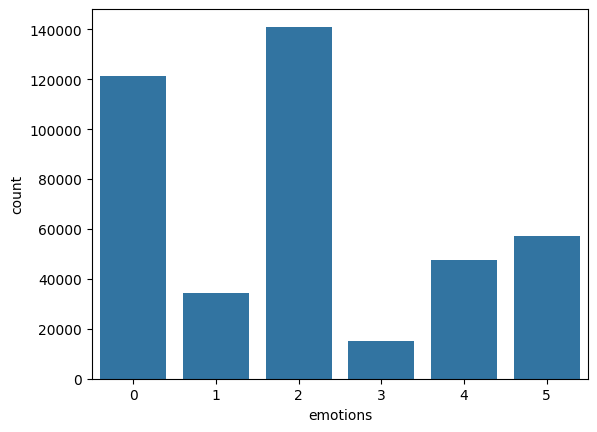

In [10]:
import seaborn as sns
sns.countplot(x='emotions', data=df)

In [20]:
# просматриваем пример текста в датасете
df['text'][15]


15                    a close friend of the family died
15    a friend female and i were on holiday on great...
15    i absolutely love feeling my sweet boy move ar...
15                a friend which i hadnt seen for years
15    a certain friend tried to push me off a seat i...
15    i actually did a good job teaching them and or...
Name: text, dtype: object

In [12]:
# создаем функцию удаления html тегов
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
# ооздаем функцию обработки текста
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [15]:
# обрабатываем текст

X = []
sentences = list(df['text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [19]:
# смотрим очищенные данные

X[15]

'know job doesnt actually thoughts feelings little jingle end every cycle makes seem excited done another load cant help sing '

In [22]:
# преобразование целевого признака

y=to_categorical(df[target_column], num_classes=6)

In [23]:
# разделяем выборку на тренировочную  и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [24]:
# преобразуемданные в числовой вид

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [25]:
# фиксируем размер словаря

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

67592

In [26]:
# фиксируем длину 30, остальным добавляем паддинги

maxlen = 30

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [27]:
# создаем словарь : слово <-> его векторное представление

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('drive/MyDrive/a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [28]:
# создаем матрицу embeddings

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [29]:
embedding_matrix.shape

(67592, 100)

In [30]:
from keras.layers import LSTM

In [ ]:
# Neural Network architecture

# lstm_model = Sequential()
# #embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
# embedding_layer = Embedding(vocab_length, 100, input_length=maxlen)

# lstm_model.add(embedding_layer)
# lstm_model.add(LSTM(32))
# lstm_model.add(Dense(100, activation='sigmoid'))
# lstm_model.add(Dense(100, activation='sigmoid'))

# lstm_model.add(Dense(6, activation='sigmoid'))


In [31]:
# архитектура модели
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_length, 32, input_length=maxlen))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(6, activation='softmax'))

In [ ]:
# model_cnn = Sequential()
# model_cnn.add(Embedding(vocab_length, 32, input_length=maxlen))
# model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
# model_cnn.add(GlobalMaxPooling1D())
# model_cnn.add(Dense(128, activation='relu'))
# model_cnn.add(Dense(6, activation='softmax'))

In [33]:
# Параметры обучения

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 32)            2162944   
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
Total params: 2166182 (8.26 MB)
Trainable params: 2166182 (8.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [34]:
# Тренировка модели

lstm_model_history = model_lstm.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
2085/2085 [==============================] - 55s 25ms/step - loss: 0.5676 - acc: 0.7862 - val_loss: 0.2328 - val_acc: 0.9078
Epoch 2/5
2085/2085 [==============================] - 19s 9ms/step - loss: 0.1993 - acc: 0.9188 - val_loss: 0.1850 - val_acc: 0.9182
Epoch 3/5
2085/2085 [==============================] - 18s 9ms/step - loss: 0.1494 - acc: 0.9308 - val_loss: 0.1669 - val_acc: 0.9212
Epoch 4/5
2085/2085 [==============================] - 15s 7ms/step - loss: 0.1322 - acc: 0.9346 - val_loss: 0.1676 - val_acc: 0.9218
Epoch 5/5
2085/2085 [==============================] - 15s 7ms/step - loss: 0.1191 - acc: 0.9386 - val_loss: 0.1594 - val_acc: 0.9250


In [35]:
# Вычисление точности модели

score = model_lstm.evaluate(X_test, y_test, verbose=1)

2606/2606 [==============================] - 9s 4ms/step - loss: 0.1646 - acc: 0.9244


In [36]:
model_lstm.save('emotions_classification.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
import json
tokenizer_json = word_tokenizer.to_json()
with open('tokenizer_emotions.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))